---
title: Learning consumption rules
execute:
  eval: false
jupyter: python3
format:
    html: default
    ipynb: default
    pdf: default
---

# Learning consumption rules

This exercise is inspired from *Individual learning about consumption*
by Todd Allen and Chris Carroll
[link](https://www.econstor.eu/bitstream/10419/72016/1/328292125.pdf)
and from *Deep Learning for Solving Economic models* by Maliar, Maliar
and Winant [link](https://web.stanford.edu/~maliars/Files/JME2021.pdf)

We consider the following consumption saving problem. An agent receives
random income $y_t = \exp(\epsilon_t)$ where
$\epsilon_t\sim \mathcal{N}(\sigma)$ ($\sigma$ is the standard
deviation.)

Consumer starts the period with available income $w_t$. The law of
motion for available income is:

$$w_t = \exp(\epsilon_t) + (w_{t-1}-c_{t-1}) r$$

where consumption $c_t \in ]0,w_t]$ is chosen in each period in order to
maximize:

$$E_t \sum_{t=0}^T \beta^t U(c_t)$$

given initial available income $w_0$.

In the questions below, we will use the following calibration:

-   $\beta = 0.9$
-   $\sigma = 0.1$
-   $T=100$
-   $U(x) = \frac{x^{1-\gamma}}{1-\gamma}$ with $\gamma=4$
-   $w_0 = 1.1$ (alternatively, consider values 0.5 and 1)

The theoretical solution to this problem is a concave function $\varphi$
such that $\varphi(x)\in ]0,x]$ and $\forall t,  c_t=\varphi(w_t)$.
Qualitatively, agents accumulate savings, up to a certain point (a
buffer stock), beyond which wealth is not increasing any more (in
expectation).

Carroll and Allen have noticed that the true solution can be
approximated very well by a simple rule:

$$\psi(x) = \min(x, \theta_0 + \theta_1 (x - \theta_0) )$$

The main question they ask in the aforementioned paper is whether it is
realistic that agents would learn good values of $\theta_0$ and
$\theta_1$ by observing past experiences.

We would like to examine this result by learning the optimal rule using
stochastic gradient descent.

In the whole notebook, we use JAX to perform the calculations.

In [1]:
from jax import numpy as jnp
from jax import random

<span class="theorem-title">**Exercise 1**</span> Define a class to
represent the parameter values

In [3]:
from dataclasses import dataclass

In [4]:
@dataclass
class Model:
    β=0.9
    σ=0.1
    γ=4.0
    r=1.04
    T=100
    # def U(self, x):
    #     return 

# -> we have tweaked the parameters a little bit so
# so that the graphs below look nicer

In [5]:
m = Model()

In [6]:
# we can also simply represent the model as a dictionary
# this represetation is useful here since it is compatible with jax JIT
p = dict(β=0.9,σ=0.1,γ=4.0,r=1.04)

<span class="theorem-title">**Exercise 2**</span> Define simple rule
fonction `consumption(w: float, θ_0:float, θ_1:float, p:Model)->float`
which compute consumption using a simple rule. What is the meaning of
$\theta_0$ and $\theta_1$? Make a plot in the space $w,c$, including
consumption rule and the line where $w_{t+1} = w_t$. Check that it works
when `w` is a JAX vector.

In [7]:
def consumption(w: float, a: float, b: float, p):
    r = a + b*(w-a)
    if w<r:
        return w
    else:
        return r

In [8]:
# this version works for basic python types
consumption(2.0, 0.9, 0.1, m)

1.01

In [9]:
# to work with vectorized arguments we need to use
# numpy or jax constructs
def consumption(w, a, b, p):
    return jnp.minimum(w, a + b*(w-a))

In [10]:
wvec = jnp.linspace(0,2,100)
θ_0 = 1.0
θ_1 = 0.05
cvec = consumption(wvec, θ_0, θ_1, m)


Text(0, 0.5, '$c_t$')

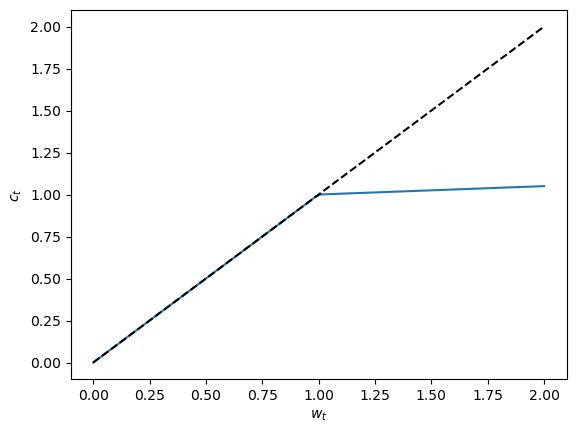

In [11]:
# let's visualize the result
from matplotlib import pyplot as plt
plt.plot(wvec, cvec)
plt.plot(wvec, wvec, color='black', linestyle='--')
plt.xlabel("$w_t$")
plt.ylabel("$c_t$")

<span class="theorem-title">**Exercise 3**</span> Write a function
`lifetime_reward(w_0: float, θ_0: float, θ_1: float, p:Model, key, T)->float`
which computes one realization of $\sum_{t=0}^T \beta^t U(c_t)$ for
initial wealth `w_0` and simple rule `θ_0`, `θ_1` and random key `key`.
Mathematically, we denote it by $\xi(\omega; \theta_0, \theta_1)$, where
$\omega$ represents the succession of random income draws. Check the
result is unchanged, when the result is computed from the same original
key.

Can you JIT compile the resulting fonction? What is the gain of using a
native JAX loop?

(hint: to use native loop, T needs to be treated as a constant parameter)

In [12]:
def lifetime_reward_unrolled(w_0, θ_0, θ_1, p, key, T=100):
    V = 0.0
    w = w_0

    γ = p['γ']
    β = p['β']
    σ = p['σ']
    r = p['r']
    
    for t in range(T):
        c = consumption(w, θ_0, θ_1, p)
        U = c**(1-γ)/(1-γ)
        V += β**t*U
        y = jnp.exp(
            random.normal(key)*σ
        )
        w = y + (w-c)*r
        subkey, _ = random.split(key)

    return V

In [13]:
key0 = random.key(1)
lifetime_reward_unrolled(1.0, 0.6, 0.04, p, key0, T=100)

Array(-9.912475, dtype=float32)

In [14]:
# we can compile the resulting function
from jax import jit
lru = jit(lifetime_reward_unrolled, static_argnames=['T'])

In [15]:
lru(2.0, 0.6, 0.05, p, key0, T=100)

Array(-7.6541395, dtype=float32)

In [16]:
%timeit lifetime_reward_unrolled(2.0, 1.0, 0.05, p, key0, T=100)

18.5 ms ± 513 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [17]:
%timeit lru(2.0, 1.0, 0.05, p, key0, T=100)
# this can to to MUCH faster evaluation (especially for large T)

20.2 μs ± 48.4 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [18]:
# hover in the lifetime_unrolled function above, jax doesn't
# actually exploit the loop structure because it uses a python
# range construct. instead it generates a code that essentially
# pastes the loop content 100 times.
# this can work for small loops but can be very inefficient when the
# loop grows larger

# lru(2.0, 1.0, 0.05, p, key0, T=10000) -> bad idea

In [19]:
# we can instead use a loop construct
# see jax documentation

from jax import lax

def lifetime_reward(w_0, θ_0, θ_1, p, key, T=100):
    V = 0.0
    w = w_0

    γ = p['γ']
    β = p['β']
    σ = p['σ']
    r = p['r']

    def loop_body(t, arg):
        w, V = arg
        c = consumption(w, θ_0, θ_1, p)
        U = c**(1-γ)/(1-γ)
        V1 = V + β**t*U
        y = jnp.exp(random.normal(key)*σ)
        w1 = y + (w-c)*r
        subkey, _ = random.split(key)
        return (w1, V1)
        
    w_, V_ = lax.fori_loop(0, T, loop_body, (w_0, 0.0))
    return V_
        

In [20]:
lifetime_reward(2.0, 0.5, 0.05, p, key0, T=100)

Array(-10.406765, dtype=float32, weak_type=True)

In [21]:
lifetime_reward(2.0, 1.01, 0.04, p, key0, T=100)

Array(-3.6886592, dtype=float32, weak_type=True)

In [22]:
# again this version can be compiled
lr = jit(lifetime_reward, static_argnames=['T'])

In [23]:
# let's compare the timings for big loops
%timeit lr(2.0, 1.0, 0.05, p, key0, T=1000)

47.2 μs ± 63 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [24]:
%timeit lru(2.0, 1.0, 0.05, p, key0, T=1000)

The slowest run took 11.56 times longer than the fastest. This could mean that an intermediate result is being cached.
141 μs ± 183 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


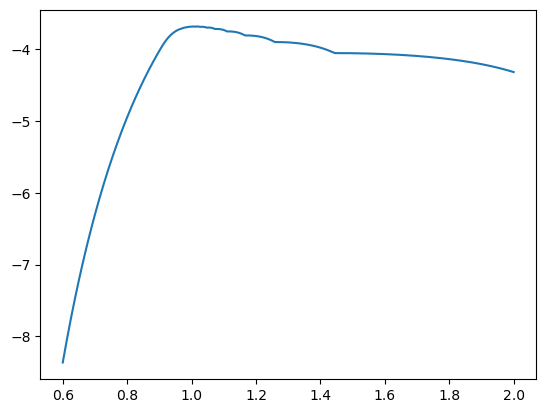

In [25]:
vec = jnp.linspace(0.6, 2.0, 1000)
yvec = [lr(2.0, h, 0.04, p, key0, T=100) for h in vec]
plt.plot(vec, yvec)

<span class="theorem-title">**Exercise 4**</span> Write a function
`lifetime_reward(w_0: float, θ_0: float, θ_1: float, p:Model, key, N, T)->float`
which computes expected lifetime reward using `N` Monte-Carlo draws.
Mathematically, we write it
$\Xi^{N}(\theta_0, \theta_1) =\frac{1}{N} \sum_1^N {\xi(\omega_N; \theta_0, \theta_1)}$.
Check empirically that standard deviation of these draws decrease
proportionally to $\frac{1}{\sqrt{N}}$ .

In [26]:
import jax
def expected_lifetime_reward(w_0, θ_0, θ_1, p, key, T=100, N=100):
    vlr = jax.vmap(
        lambda w, key: lr(w, θ_0, θ_1, p, key, T=T),
    )
    wvec = jnp.repeat(w_0, N)
    keys = random.split(key, N)
    return vlr(wvec, keys).mean()

In [27]:
%time expected_lifetime_reward(2.0,0.6, 0.05, p, key0, T=100)

CPU times: user 529 ms, sys: 9.02 ms, total: 538 ms
Wall time: 527 ms


Array(-6.8929925, dtype=float32)

In [28]:
elr = jit(expected_lifetime_reward)
elr(2.0, 1.0, 0.05, p, key0, T=100);

/home/pablo/.local/opt/micromamba/envs/bbank/lib/python3.11/site-packages/jax/_src/core.py:691: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(
/home/pablo/.local/opt/micromamba/envs/bbank/lib/python3.11/site-packages/jax/_src/core.py:691: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(


In [29]:
# again, the compiled version is much faster
%time elr(2.0, 1.0, 0.05, p, key0, T=100)

CPU times: user 2.02 ms, sys: 21 μs, total: 2.04 ms
Wall time: 1.48 ms


Array(-3.0192175, dtype=float32)

<span class="theorem-title">**Exercise 5**</span> Using a high enough
number for `N`, compute optimal values for $\theta_0$ and $\theta_1$.
What is the matching value for the objective function converted into an
equivalent stream of deterministic consumption ? That is if `V` is the
approximated value computed above, what is $\bar{c}\in R$ such that
$V= \sum_{t=0}^T \beta^t U(\bar{c})$ ?

In [30]:
K = 100
t0_vec = jnp.linspace(0.5, 4.0,  K)
t1_vec = jnp.linspace(0.0, 0.4, K)

In [31]:
t0_ = t0_vec[:,None].repeat(K,axis=1).ravel()
t1_ = t1_vec[None,:].repeat(K,axis=0).ravel()
# This is a mesh ( the lines of np.column_stack([t0_,t1_])  contain all possible combinations of t0 and t1

# we compute random keys for each point of the mesh


In [32]:
p = dict(β=0.9,σ=0.1,γ=4.0,r=1.04)

In [33]:
w_0_ = 2.0
N = 1000 # this needs to be rather large for the plot to be smooth
keys = random.split(key0, K*K)
vals = jax.vmap(
    lambda t0, t1, key: expected_lifetime_reward(w_0_, t0, t1, p, key, T=100, N=N)
)(
    t0_, t1_, keys
)

In [34]:
vals = vals.reshape((K,K))

Text(0.5, 1.0, 'Lifetime Reward')

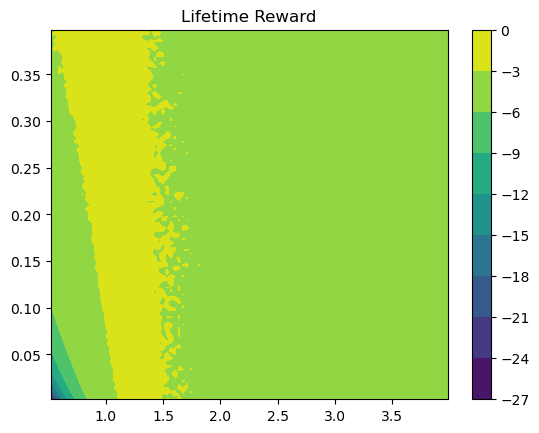

In [63]:
# we can represent the values as a heatmap
import matplotlib.pyplot as plt
import numpy as np
plt.contourf(
    np.array(vals.T),
    origin='lower',
    extent=(t0_vec.min(), t0_vec.max(), t1_vec.min(), t1_vec.max()),
    # vmin=-11,
    # levels=np.linspace(-15, -9, 40),
    
)
plt.colorbar()
plt.title("Lifetime Reward")

In [64]:
# for a more insightful plot, we can convert into consumption equivalents
cvals = (vals*(1-p['γ']))**(1/(1-p['γ']))
# let's normalize as % loss from the maximum
cvals_loss = ((cvals.max()-cvals)/cvals.max())

In [65]:
cvals

Array([[0.2320815 , 0.24623036, 0.25717124, ..., 0.4804254 , 0.482437  ,
        0.47948226],
       [0.24849133, 0.26192278, 0.27280337, ..., 0.47907487, 0.4808672 ,
        0.47883892],
       [0.26490113, 0.27778888, 0.2879123 , ..., 0.48178297, 0.4817273 ,
        0.48342937],
       ...,
       [0.47022584, 0.4712539 , 0.47367927, ..., 0.4723089 , 0.4723742 ,
        0.47379422],
       [0.4712465 , 0.47158557, 0.47210145, ..., 0.46918964, 0.47077164,
        0.47395906],
       [0.47214964, 0.47252044, 0.471062  , ..., 0.4686527 , 0.4717124 ,
        0.47336236]], dtype=float32)

Text(0.5, 1.0, 'Lifetime Reward (consumption equivalent)')

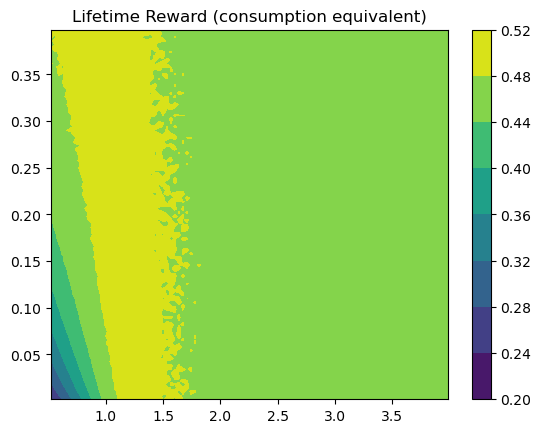

In [67]:
# we can represent the values as a heatmap
import matplotlib.pyplot as plt
import numpy as np
plt.contourf(
    np.array(cvals.T),
    origin='lower',
    extent=(t0_vec.min(), t0_vec.max(), t1_vec.min(), t1_vec.max()),
    # levels=[0.104 0.112]
)
plt.colorbar()
plt.title("Lifetime Reward (consumption equivalent)")

<span class="theorem-title">**Exercise 6**</span> Using a high enough
number for `N`, make contour plots of lifetime rewards as a function of
`θ_0` and `θ_1`. Ideally, represent lines with $1\%$ consumption loss,
$5\%$ and $10\%$ deterministic consumption loss w.r.t. to maximum.

Text(0.5, 1.0, 'Lifetime Reward (% deviation from maximum)')

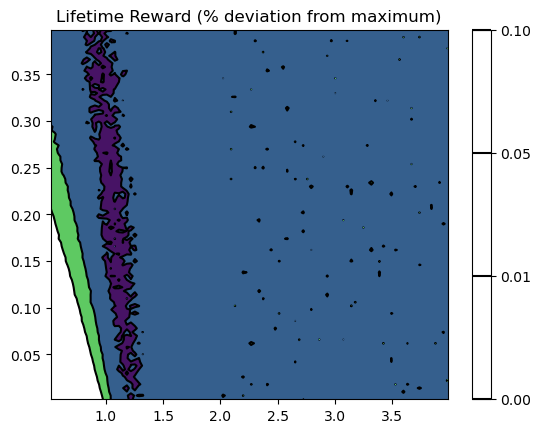

In [68]:
# we can add the contour lines on the same plot
#
levels=[0, 0.01, 0.05, 0.1]
import matplotlib.pyplot as plt
import numpy as np
plt.contourf(
    np.array(cvals_loss.T),
    origin='lower',
    extent=(t0_vec.min(), t0_vec.max(), t1_vec.min(), t1_vec.max()),
    levels=levels
)
plt.contour(
    np.array(cvals_loss.T),
    origin='lower',
    extent=(t0_vec.min(), t0_vec.max(), t1_vec.min(), t1_vec.max()),
    levels=levels,
    colors='black'
) 
plt.colorbar()

plt.title("Lifetime Reward (% deviation from maximum)")

## Learning to save

We now focus on the number of steps it takes to optimize $\theta_0$,
$\theta_1$.\_\_

<span class="theorem-title">**Exercise 7**</span> Implement a function
`∇(θ:Vector, T, N)::Vector` which computes the gradient of the objective
w.r.t. `θ==[θ_0,θ_1]`\_\_

In [69]:
def grad(θ, key, T=100, N=10):
    fun = lambda t: expected_lifetime_reward(w_0_, t[0], t[1], p, key, T=100, N=N)
    g = jax.grad(fun)(θ)
    return g

In [70]:
v0 = jnp.array([1.0, 0.0])
grad(v0, key0)

Array([ 8.861146, 14.778807], dtype=float32)

<span class="theorem-title">**Exercise 8**</span> Implement a gradient
descent algorithm to maximize $\Xi^N(\theta_0, \theta_1)$ using learning
rate $\lambda \in ]0,1]$. Stop after a predefined number of iterations.
Compare convergence speed for different values of $\lambda$ and plot
them on the $\theta_0, \theta_1$ plan. How many steps does it take to
enter the `1%` error zone? The `5%` and the `10%` error zone?

In [71]:
# let's define an objective function (to minimize) that returns the value and the gradient
def fobj(θ, key, T=100, N=10):
    def fun(t):
        v = expected_lifetime_reward(w_0_, t[0], t[1], p, key, T=T, N=N)
        # convert into consumption equivalent
        c = (v*(1-p['γ']))**(1/(1-p['γ']))
        return c
    # g = jax.grad(fun)
    # return fun(theta), g(theta)
    # instead of the commented code above we can return at once the gradient and the value with:
    return jax.value_and_grad(fun)(θ)

In [72]:
fobj_jitted = jit(fobj, static_argnames=['N'])

In [73]:
%time fobj_jitted(v0, key0, N=100)

CPU times: user 298 ms, sys: 13.9 ms, total: 312 ms
Wall time: 299 ms


(Array(0.46036172, dtype=float32),
 Array([0.35756832, 0.7256772 ], dtype=float32))

In [74]:
from tqdm.notebook import tqdm

In [75]:
v0 = jnp.array([1.0, 0.00])

In [76]:
# let's write a naive code
λ = 0.01
M = 5000 # total number of training steps
v = v0.copy()
key = key0.copy()
values = []
guesses = []
for m in tqdm(range(M)):
    key, _ = random.split(key)
    f, df = fobj_jitted(v, key, N=N)
    # print(f)
    guesses.append(v)
    values.append(f)
    # update guess
    v = v+λ*df # maximize with gradient ascent

  0%|          | 0/5000 [00:00<?, ?it/s]

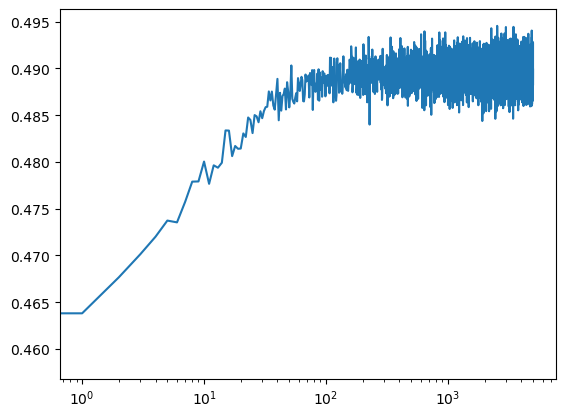

In [77]:
# convergenced is obtained rather quickly (note the log x-scale)
fig, ax = plt.subplots()
ax.plot(values)
ax.set_xscale("log")

Text(0.5, 1.0, 'Lifetime Reward: Convergence of Gradient Ascent')

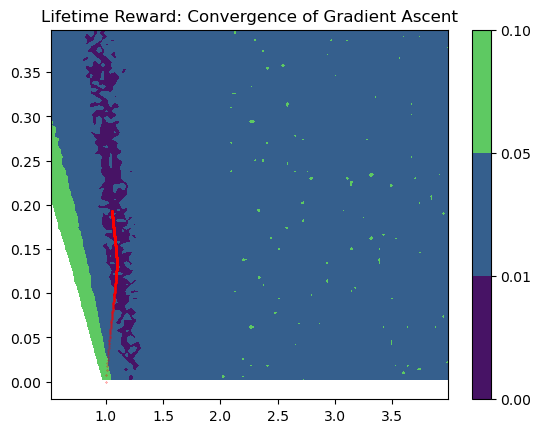

In [83]:
# we can also represent the convergence on a heatmap
import matplotlib.pyplot as plt
import numpy as np
levels=[0, 0.01, 0.05, 0.1]

plt.contourf(
    np.array(cvals_loss.T),
    origin='lower',
    extent=(t0_vec.min(), t0_vec.max(), t1_vec.min(), t1_vec.max()),
    # extent=(t1_vec.min(), t1_vec.max(), t0_vec.min(), t0_vec.max()),
    # levels=np.linspace(0.,0.5,20)
    levels=levels
    # levels=[-3,-2,-1.0,-0.5,-0.4,-0.3,-0.2,-0.1, -0.05]
)
# plt.plot([e[1] for e in guesses], [e[0] for e in guesses], '.')
plt.plot([e[0] for e in guesses], [e[1] for e in guesses], '.', markersize=0.5, color='red')
plt.colorbar()
plt.title("Lifetime Reward: Convergence of Gradient Ascent")
# plt.plot([v[0]], [v[1]],'o')

Text(0, 0.5, '$c_t$')

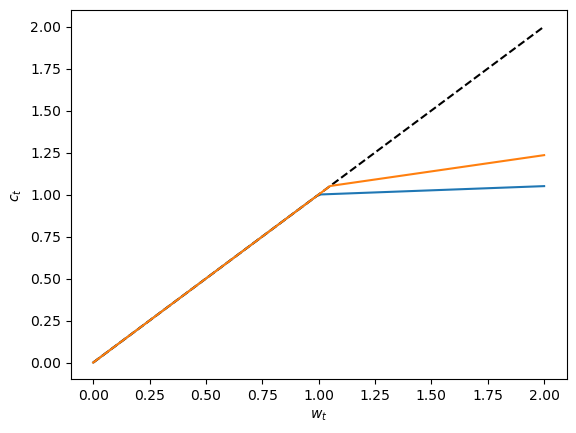

In [84]:
# let's visualize the result
c_learned = consumption(wvec, v[0], v[1], p)
from matplotlib import pyplot as plt
plt.plot(wvec, cvec)
plt.plot(wvec, wvec, color='black', linestyle='--')
plt.plot(wvec, c_learned)
plt.xlabel("$w_t$")
plt.ylabel("$c_t$")

Even for big N, the evaluated value of ∇ are stochastic, and always
slightly inaccurate. In average, they are non-biased and the algorithm
converges in expectation (it fluctuates around the maximum). This is
called the stochastic gradient method.

<span class="theorem-title">**Exercise 9**</span> What are the values of
$N$ and $\lambda$ which minimize the number of iterations before
reaching the target zones (at 1%, 2%, etc…)? How many simulations
periods does it correspond to? Would you say it is realistic that
consumers learn from their own experience?

In [85]:
# in order to perform sensitivity analysis, let's wrap the code above in a funciton
# let's write a naive code
def train(λ=0.01, M=5000, N=1000):
    v = v0.copy()
    key = key0.copy()
    values = []
    guesses = []
    for m in tqdm(range(M)):
        key, _ = random.split(key)
        f, df = fobj_jitted(v, key, N=N)
        # print(f)
        guesses.append(v)
        values.append(f)
        # update guess
        v = v+λ*df # maximize with gradient ascent
    return guesses, values

In [86]:
# compare some learning rates for high numbers of N i.e. precise jacobians
guesses_0001, values_0001 = train(λ=0.001)
guesses_001, values_001 = train(λ=0.01)
guesses_01, values_01 = train(λ=0.1)

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

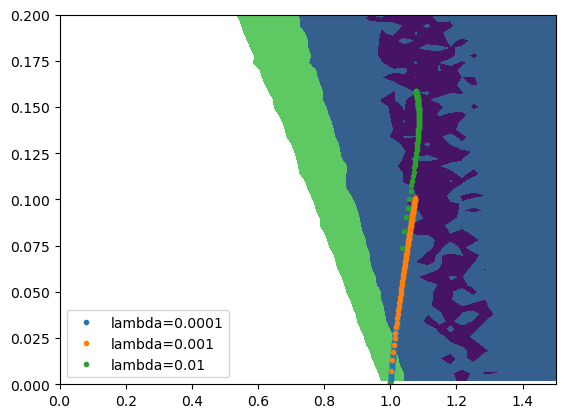

In [87]:
# we can also represent the convergence on a heatmap

import matplotlib.pyplot as plt
import numpy as np
levels=[0, 0.01, 0.05, 0.1]

plt.contourf(
    np.array(cvals_loss.T),
    origin='lower',
    extent=(t0_vec.min(), t0_vec.max(), t1_vec.min(), t1_vec.max()),
    # extent=(t1_vec.min(), t1_vec.max(), t0_vec.min(), t0_vec.max()),
    # levels=np.linspace(0.,0.5,20)
    levels=levels
    # levels=[-3,-2,-1.0,-0.5,-0.4,-0.3,-0.2,-0.1, -0.05]
)
# plt.plot([e[1] for e in guesses], [e[0] for e in guesses], '.')
H = 100
plt.plot([e[0] for e in guesses_0001[:H]], [e[1] for e in guesses_0001[:H]], '.', label='lambda=0.0001')
plt.plot([e[0] for e in guesses_001[:H]], [e[1] for e in guesses_001[:H]], '.', label='lambda=0.001')
plt.plot([e[0] for e in guesses_01[:H]], [e[1] for e in guesses_01[:H]], '.', label='lambda=0.01')
plt.xlim(0, 1.5)
plt.ylim(0, 0.2)
plt.legend(loc='lower left')
# plt.colorbar()

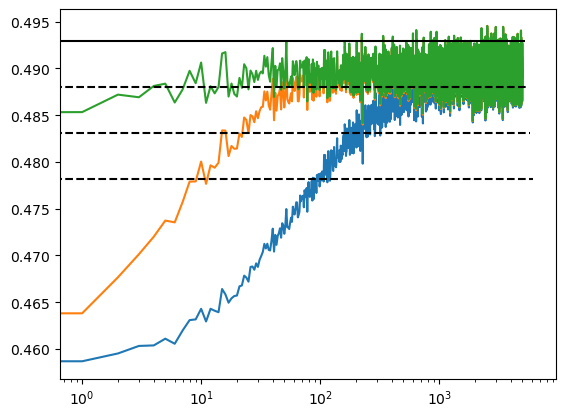

In [88]:
# we can also visualize the training by looking at objective function
# not that seemingly high asymptotic volatility comes from the log x-range

cm = cvals.max()

fig,ax = plt.subplots()
ax.plot(values_0001)
ax.plot(values_001)
ax.plot(values_01)
ax.hlines(y=cm, xmin=plt.xlim()[0], xmax=plt.xlim()[1], label="optimal", color='black')
ax.hlines(y=cm*0.99, xmin=plt.xlim()[0], xmax=plt.xlim()[1], label="optimal", color='black', linestyle='dashed')
ax.hlines(y=cm*0.98, xmin=plt.xlim()[0], xmax=plt.xlim()[1], label="optimal", color='black', linestyle='dashed')
ax.hlines(y=cm*0.97, xmin=plt.xlim()[0], xmax=plt.xlim()[1], label="optimal", color='black', linestyle='dashed')
ax.set_xscale('log')

In [89]:
# now let' s reduce the number of draws for the calculation of Xi
guesses_10_0001, values_10_0001 = train(λ=0.001, N=100)
guesses_10_001, values_10_001 = train(λ=0.01, N=100)
guesses_10_01, values_10_01 = train(λ=0.1, N=100)
guesses_10_1, values_10_1 = train(λ=1, N=100)

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

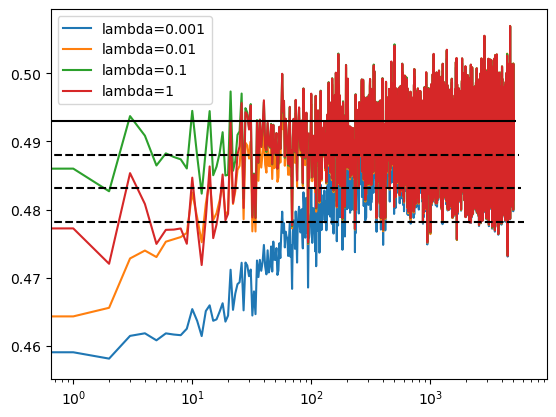

In [90]:
# we can see that the objective has much more volatility
fig,ax = plt.subplots()
ax.plot(values_10_0001, label='lambda=0.001')
ax.plot(values_10_001, label='lambda=0.01')
ax.plot(values_10_01, label='lambda=0.1')
ax.plot(values_10_1, label='lambda=1')
ax.hlines(y=cm, xmin=plt.xlim()[0], xmax=plt.xlim()[1], color='black')
ax.hlines(y=cm*0.99, xmin=plt.xlim()[0], xmax=plt.xlim()[1], color='black', linestyle='dashed')
ax.hlines(y=cm*0.98, xmin=plt.xlim()[0], xmax=plt.xlim()[1], color='black', linestyle='dashed')
ax.hlines(y=cm*0.97, xmin=plt.xlim()[0], xmax=plt.xlim()[1], color='black', linestyle='dashed')
plt.legend(loc='upper left')
ax.set_xscale('log')

Text(0.5, 1.0, 'Lifetime Reward: Convergence of Gradient Ascent (N=100)')

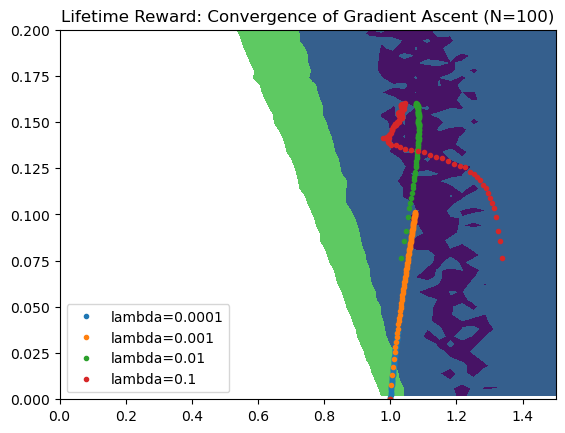

In [95]:
# but the path for the guesses, look very similar to the one obtained with N=10000

import matplotlib.pyplot as plt
import numpy as np
levels=[0, 0.01, 0.05, 0.1]

plt.contourf(
    np.array(cvals_loss.T),
    origin='lower',
    extent=(t0_vec.min(), t0_vec.max(), t1_vec.min(), t1_vec.max()),
    # extent=(t1_vec.min(), t1_vec.max(), t0_vec.min(), t0_vec.max()),
    # levels=np.linspace(0.,0.5,20)
    levels=levels
    # levels=[-3,-2,-1.0,-0.5,-0.4,-0.3,-0.2,-0.1, -0.05]
)
# plt.plot([e[1] for e in guesses], [e[0] for e in guesses], '.')
H = 100
plt.plot([e[0] for e in guesses_10_0001[:H]], [e[1] for e in guesses_10_0001[:H]], '.', label='lambda=0.0001')
plt.plot([e[0] for e in guesses_10_001[:H]], [e[1] for e in guesses_10_001[:H]], '.', label='lambda=0.001')
plt.plot([e[0] for e in guesses_10_01[:H]], [e[1] for e in guesses_10_01[:H]], '.', label='lambda=0.01')
plt.plot([e[0] for e in guesses_10_1[:H]], [e[1] for e in guesses_10_01[:H]], '.', label='lambda=0.1')

plt.xlim(0, 1.5)
plt.ylim(0, 0.2)
plt.legend(loc='lower left')
plt.title("Lifetime Reward: Convergence of Gradient Ascent (N=100)")

Text(0, 0.5, '$\\theta_1$')

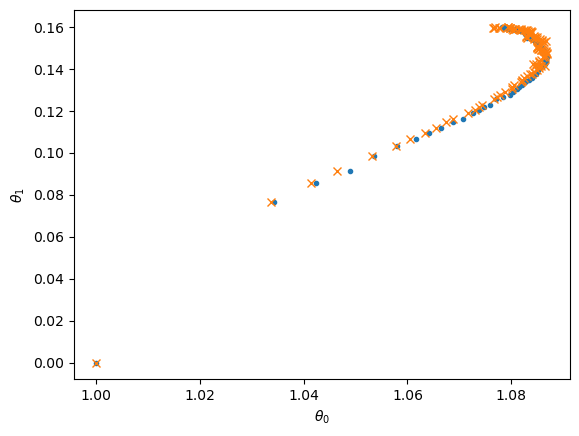

In [96]:
# compare with lambda=0.01, the paths obtained with N=10000 and N=100
plt.plot([e[0] for e in guesses_01[:H]], [e[1] for e in guesses_10_01[:H]], '.',  color='C0', label="N=10000")
plt.plot([e[0] for e in guesses_10_01[:H]], [e[1] for e in guesses_10_01[:H]], 'x',  color='C1', label="N=10")
plt.xlabel('$\\theta_0$')
plt.ylabel('$\\theta_1$')


In [97]:
# Conclusion, to learn the optimal decision rule, it is not needed to compute the objective very precisely
# as long as its gradient is computed with sufficient precision to learn the optimal decision rule.

# For the learning rate, lambda=0.1 is the best values among those we have tested. Of course, this can be improved...